## Dollar Cost Averaging Strategy Explanation using Python Backtesting

In [20]:
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt

In [21]:
# import data
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    return stockData

stockList = ['VTS.AX']

endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=1000)

In [22]:
stockData = get_data(stockList[0], startDate, endDate)

[*********************100%%**********************]  1 of 1 completed


In [23]:
actualStart = stockData.index[0]

In [24]:
data = bt.feeds.PandasData(dataname=stockData)

In [25]:
class BuyAndHold(bt.Strategy):

    def start(self):
        self.val_start = self.broker.get_cash()    

    def nextStart(self):
        size = math.floor((self.broker.get_cash() - 10) / self.data[0])
        self.buy(size=size)

    def stop(self):
        # Calculate actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1
        print('-'*50)
        print('Buy and Hold')
        print("Starting Value: ${:,.2f}".format(self.val_start))
        print('ROI: {:.2f}%'.format(self.roi*100.0))
        print('Annualized: {:.2f}%'.format(100*((1 + self.roi)**(365/(endDate - actualStart).days) - 1)))
        print('Gross Return: ${:,.2f}%'.format(self.broker.get_value() / self.val_start))

In [26]:
class BuyAndHold_More_Fund(bt.Strategy):
    
    params = dict(
        monthly_cash=1000,
        monthly_range = [5,20]
    )

    def __init__(self):
        self.order = None
        self.totalcost = 0
        self.cost_wo_bro = 0
        self.units = 0
        self.times = 0

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def start(self):
        self.broker.set_fundmode(fundmode=True, fundstartval=100.0)
        
        self.cash_start = self.broker.get_cash()
        self.val_start = 100.0

        # Add a timer
        self.add_timer(
            when= bt.timer.SESSION_START,
            monthdays = [i for i in self.p.monthly_range],
            monthcarry = True,
            # timername='buytimer'
        )

    def notify_timer(self, timer, when, *args):
        self.broker.add_cash(self.p.monthly_cash)
        target_value = self.broker.get_value() + self.p.monthly_cash - 10
        self.order_target_value(target=target_value)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return 

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price %.2f, Cost %.2f, Comm %.2f, Size %.0f' %
                    (order.executed.price,
                    order.executed.value,
                    order.executed.comm,
                    order.executed.size)
                )
                self.units += order.executed.size
                self.totalcost += order.executed.value + order.executed.comm
                self.cost_wo_bro += order.executed.value
                self.times += 1
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order was canceled/Margin/Rejected')
            print(order.status, [order.Canceled, order.Margin, order.Rejected])

        self.order = None

    def stop(self):
        # Calculate actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1
        self.froi = (self.broker.get_fundvalue() / self.val_start)
        value = self.datas[0].close * self.units + self.broker.get_cash()
        print('-'*50)
        print('Buy and Buy More')
        print("Time in Market: {:.1f} years".format((endDate - actualStart).days/365))
        print('#Times: {:.2f}%'.format(self.times))
        print('Value: {:.2f}%'.format(value))
        print('Cost: ${:,.2f}%'.format(self.totalcost))
        print('Gross Return: ${:,.2f}%'.format((value - self.totalcost)))
        print('Gross %: {:.2f}%'.format((value/self.totalcost - 1) * 100))
        print('ROI: {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value: {:.2f}%'.format(self.froi))
        print('Annualised: {:.2f}%'.format(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1)))

In [27]:
class FixedCommissionScheme(bt.CommInfoBase):
    paras = (
        ('commission', 10),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED)
    )

    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

In [28]:
def run(data):
    # BUY AND HOLD
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(BuyAndHold)

    # Broker information
    broker_args = dict(coc = True)
    cerebro.broker = bt.brokers.BackBroker(**broker_args)
    comminfo = FixedCommissionScheme()
    cerebro.broker.addcommissioninfo(comminfo)

    cerebro.broker.set_cash(100000)

    # BUY AND BUY MORE
    cerebro1 = bt.Cerebro()
    cerebro1.adddata(data)
    cerebro1.addstrategy(BuyAndHold_More_Fund)

    # Broker information
    broker_args = dict(coc = True)
    cerebro1.broker = bt.brokers.BackBroker(**broker_args)
    comminfo = FixedCommissionScheme()
    cerebro1.broker.addcommissioninfo(comminfo)

    cerebro1.broker.set_cash(1000)
    cerebro1.run()
    cerebro.run()
    cerebro.plot(iplot=False, style='candlestick')
    cerebro1.plot(iplot=False, style='candlestick')

2021-08-31, BUY EXECUTED, Price 319.29, Cost 1915.74, Comm 0.00, Size 6
2021-09-07, BUY EXECUTED, Price 315.32, Cost 945.96, Comm 0.00, Size 3
2021-10-06, BUY EXECUTED, Price 305.59, Cost 916.77, Comm 0.00, Size 3
2021-10-21, BUY EXECUTED, Price 310.87, Cost 932.61, Comm 0.00, Size 3
2021-11-08, BUY EXECUTED, Price 326.50, Cost 979.50, Comm 0.00, Size 3
2021-11-23, BUY EXECUTED, Price 334.08, Cost 1002.24, Comm 0.00, Size 3
2021-12-07, BUY EXECUTED, Price 331.00, Cost 993.00, Comm 0.00, Size 3
2022-01-06, BUY EXECUTED, Price 334.35, Cost 1003.05, Comm 0.00, Size 3
2022-01-21, BUY EXECUTED, Price 316.47, Cost 1265.88, Comm 0.00, Size 4
2022-02-08, BUY EXECUTED, Price 319.30, Cost 957.90, Comm 0.00, Size 3
2022-03-08, BUY EXECUTED, Price 290.49, Cost 871.47, Comm 0.00, Size 3
2022-04-06, BUY EXECUTED, Price 303.00, Cost 909.00, Comm 0.00, Size 3
2022-04-21, BUY EXECUTED, Price 301.56, Cost 1206.24, Comm 0.00, Size 4
2022-05-06, BUY EXECUTED, Price 297.67, Cost 893.01, Comm 0.00, Size 3
2

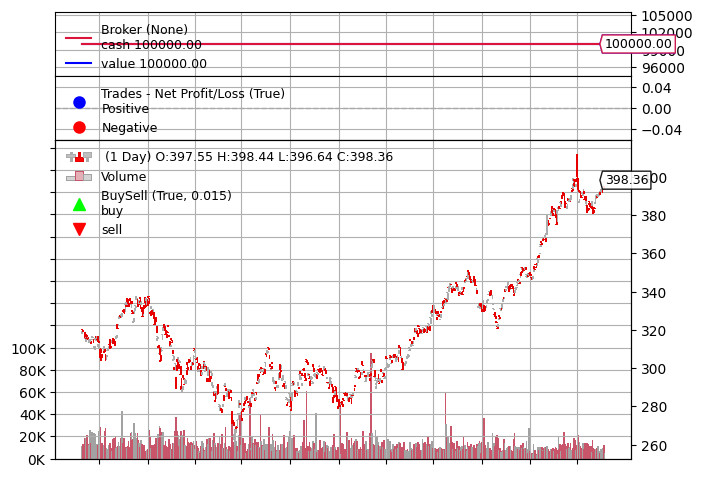

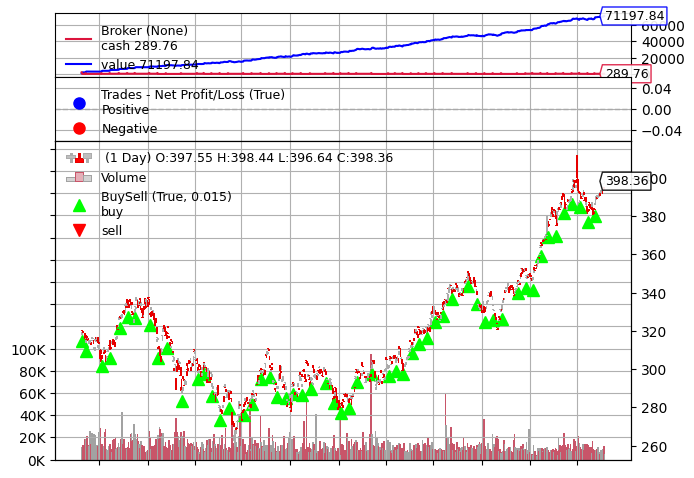

In [29]:
run(data)